In [1]:
import pandas as pd

In [74]:
filename = '3_clusters_1000.csv'
df = pd.read_csv(filename, on_bad_lines='warn')

In [75]:
df.head()

,firstname,Cluster,Highest_probF_ethnicity,Highest_probF_value,Genni
0,Lenell,0,ENGLISH,64.166,F
1,Leroy,0,ENGLISH,81.403,M
2,Latham,0,INDIAN,50.739,M
3,Lemoyne,0,HISPANIC,32.121,M
4,Lindley,0,ENGLISH,75.487,M


In [116]:
## Creates a df with information about each cluster

cluster_sizes = df['Cluster'].value_counts().reset_index().rename(columns={'index': 'Cluster', 'Cluster': 'Size'})

# Calculate the percentage of rows with the highest ethnicity for each cluster
highest_ethnicity_percent = df.groupby('Cluster')['Highest_probF_ethnicity'].apply(lambda x: (x.value_counts(normalize=True).max() * 100).round(2)).reset_index(name='Ethnicity_Acc')

# Calculate the percentage of rows with the highest gender for each cluster
highest_gender_percent = df.groupby('Cluster')['Genni'].apply(lambda x: (x.value_counts(normalize=True).max() * 100).round(2)).reset_index(name='Gender_Acc')

# Find the ethnicity with the highest count for each cluster
highest_ethnicity = df.groupby('Cluster')['Highest_probF_ethnicity'].apply(lambda x: x.value_counts().idxmax()).reset_index(name='Highest_probF_ethnicity')

# Find the gender with the highest count for each cluster
highest_gender = df.groupby('Cluster')['Genni'].apply(lambda x: x.value_counts().idxmax()).reset_index(name='Genni')

# Merge the DataFrames
result_df = pd.merge(cluster_sizes, highest_ethnicity, on='Cluster')
result_df = pd.merge(result_df, highest_ethnicity_percent, on='Cluster')
result_df = pd.merge(result_df, highest_gender, on='Cluster')
result_df = pd.merge(result_df, highest_gender_percent, on='Cluster')

result_df = result_df.sort_values(by='Cluster').reset_index(drop=True)

# Print the combined DataFrame
result_df


,Cluster,Size,Highest_probF_ethnicity,Ethnicity_Acc,Genni,Gender_Acc
0,0,104,ENGLISH,60.58,M,90.38
1,1,25,HISPANIC,36.00,F,64.00
2,2,36,NORDIC,33.33,M,69.44
3,3,36,HISPANIC,30.56,M,63.89
4,4,12,CHINESE,25.00,F,100.00
...,...,...,...,...,...,...
995,995,7,ENGLISH,42.86,F,100.00
996,996,2,ENGLISH,50.00,M,100.00
997,997,28,GREEK,50.00,M,85.71
998,998,2,GREEK,100.00,M,100.00


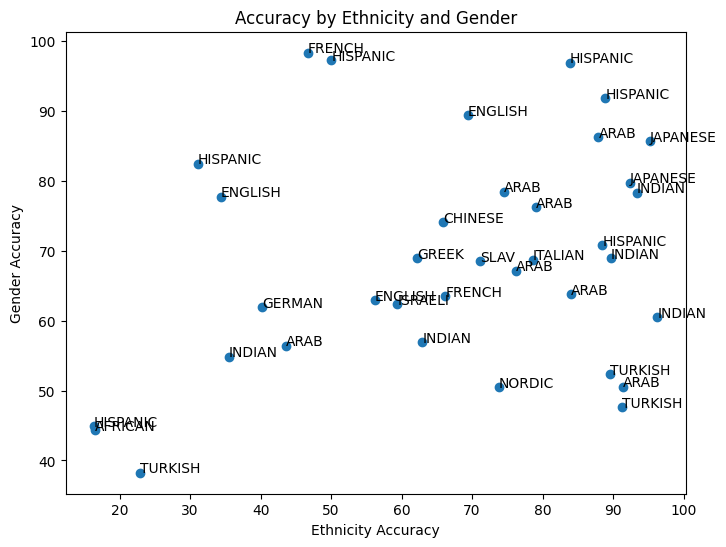

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))  # Set the figure size

# Scatter plot
plt.scatter(result_df['Ethnicity_Acc'], result_df['Gender_Acc'])

# Add labels to the points
for i in range(len(result_df)):
    plt.text(result_df['Ethnicity_Acc'][i], result_df['Gender_Acc'][i], result_df['Highest_probF_ethnicity'][i])

# Set the axis labels
plt.xlabel('Ethnicity Accuracy')
plt.ylabel('Gender Accuracy')

# Set the title
plt.title('Accuracy by Ethnicity and Gender')

# Show the plot
plt.show()


In [120]:
## Only takes clusters with high ethnicity/gender agreement, only one per ethnicity group

# Filter clusters with Ethnicity_Acc > 50% and Gender_Acc > 50%
filtered_df = result_df[(result_df['Ethnicity_Acc'] > 50) & (result_df['Gender_Acc'] > 50)]

# Only keep size of 10 or above
filtered_df = filtered_df[filtered_df['Size'] > 9]

# Print the filtered DataFrame
print(filtered_df.reset_index(drop=True))
print(filtered_df['Size'].mean())

# Keep only one row per ethnicity with the highest Ethnicity_Acc * Gender_Acc
# top_clusters_df = (filtered_df
#                    .assign(Acc_Product=filtered_df['Ethnicity_Acc'] * filtered_df['Gender_Acc'])
#                    .sort_values('Acc_Product', ascending=False)
#                    .drop_duplicates(['Highest_probF_ethnicity', 'Genni'])
#                    .drop('Acc_Product', axis=1)
#                    )

# test set: 17 viable clusters

# Mini-batch k-means on 36000 names, batch size 2048 results
# 50 cluster set: 20 viable clusters, 74 and 75 avg
# 100 cluster set: 24 viable clusters, 75 and 80 avg
# 500 cluster set: 35 viable clusters, 84 and 86 avg, but names too similar
# 1000 cluster set: 37 viable clusters, 87 and 90 avg, but names too similar


     Cluster  Size Highest_probF_ethnicity  Ethnicity_Acc Genni  Gender_Acc
0          0   104                 ENGLISH          60.58     M       90.38
1          5    18                    SLAV          55.56     M       88.89
2          7    39                 CHINESE         100.00     M       71.79
3          9    46                JAPANESE          91.30     M       69.57
4         11    42                  INDIAN          85.71     F       78.57
..       ...   ...                     ...            ...   ...         ...
350      984    52                JAPANESE          88.46     M       92.31
351      985    13                  KOREAN          69.23     M       69.23
352      987    25                    ARAB          60.00     F       52.00
353      992    18                  NORDIC          66.67     F       55.56
354      993    44                 ENGLISH          68.18     F       81.82

[355 rows x 6 columns]
49.72394366197183


In [126]:
# Group 'filtered_df' by 'Highest_probF_ethnicity' and 'Genni'
grouped_df = filtered_df.groupby(['Highest_probF_ethnicity', 'Genni'])
# Create an empty DataFrame to store the selected rows from 'results_df'
selected_rows_df = pd.DataFrame()

# Iterate over each group in 'filtered_df'
for group_id, (group_name, group_data) in enumerate(grouped_df):
    # Get the 'Highest_probF_ethnicity' and 'Genni' values for the current group
    highest_probF_ethnicity, genni = group_name
    print(group_name)
    print(group_data['Cluster'].to_list())
    cluster_list = group_data['Cluster'].to_list()

    # Find all matching rows in 'results_df' with the same 'Highest_probF_ethnicity' and 'Genni'
    # from a list of clusters
    matching_rows = df[
        (df['Highest_probF_ethnicity'] == highest_probF_ethnicity) &
        (df['Genni'] == genni) &
        (df['Cluster'].isin(cluster_list))
    ]
    
    # Take a random 10 rows from the matching rows
    selected_rows = matching_rows.sample(n=10, random_state=32)
    selected_rows['group_id'] = group_id

    # Append the selected rows to the 'selected_rows_df' DataFrame
    selected_rows_df = selected_rows_df.append(selected_rows)



('AFRICAN', 'F')
[920]
('AFRICAN', 'M')
[193, 251, 493, 512]
('ARAB', 'F')
[259, 264, 274, 334, 338, 423, 527, 765, 769, 812, 871, 977, 987]
('ARAB', 'M')
[12, 42, 79, 91, 97, 98, 123, 124, 126, 144, 157, 169, 228, 295, 300, 305, 316, 326, 402, 487, 507, 509, 547, 656, 780, 836, 856, 859, 906, 949]
('BALTIC', 'M')
[465, 753]
('CHINESE', 'F')
[293, 323, 359, 553, 819]
('CHINESE', 'M')
[7, 52, 92, 94, 102, 158, 160, 173, 186, 238, 309, 310, 332, 347, 372, 374, 387, 408, 428, 429, 433, 451, 502, 528, 584, 617, 625, 786, 823, 839]
('DUTCH', 'F')
[20, 486]
('DUTCH', 'M')
[203, 687]
('ENGLISH', 'F')
[15, 30, 73, 77, 130, 149, 200, 212, 325, 331, 410, 425, 446, 506, 538, 558, 573, 599, 601, 603, 723, 724, 738, 759, 774, 837, 860, 955, 966, 973, 980, 983, 993]
('ENGLISH', 'M')
[0, 113, 231, 311, 370, 415, 628, 706, 770, 798, 847, 890, 957, 962]
('FRENCH', 'F')
[35, 254, 302, 883]
('FRENCH', 'M')
[48, 533, 930]
('GERMAN', 'F')
[737, 795]
('GERMAN', 'M')
[28, 36, 61, 106, 202, 456, 494, 583, 644

/var/folders/9v/1gmd4w3d2nnb1nrlmx_01jf80000gp/T/ipykernel_4203/3697938929.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_rows_df = selected_rows_df.append(selected_rows)
/var/folders/9v/1gmd4w3d2nnb1nrlmx_01jf80000gp/T/ipykernel_4203/3697938929.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_rows_df = selected_rows_df.append(selected_rows)
/var/folders/9v/1gmd4w3d2nnb1nrlmx_01jf80000gp/T/ipykernel_4203/3697938929.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_rows_df = selected_rows_df.append(selected_rows)
/var/folders/9v/1gmd4w3d2nnb1nrlmx_01jf80000gp/T/ipykernel_4203/3697938929.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

In [127]:
# Print the selected names DataFrame
print(selected_rows_df)

       firstname  Cluster Highest_probF_ethnicity  Highest_probF_value Genni  \
33390   Aissatou      920                 AFRICAN               83.180     F   
33404    Aissata      920                 AFRICAN               78.696     F   
33393    Aminata      920                 AFRICAN               77.497     F   
33406  Halimatou      920                 AFRICAN               81.341     F   
33407     Bintou      920                 AFRICAN               73.911     F   
...          ...      ...                     ...                  ...   ...   
11742      Harun      273                 TURKISH               84.521     M   
33468      Engin      922                 TURKISH               97.957     M   
33581   Alpaslan      922                 TURKISH              100.000     M   
33538  Hayrullah      922                 TURKISH               98.805     M   
33555     Ataman      922                 TURKISH               99.495     M   

       group_id  
33390         0  
334

In [128]:
selected_rows_df.to_csv('../data/4_name_groups.csv')